# Stochastic Gradient Descent From Scratch

This notebook illustrates the nature of the Stochastic Gradient Descent (SGD) and walks through all the necessary steps to create SGD from scratch in Python. Gradient Descent is an essential part of many machine learning algorithms, including neural networks. To understand how it works you will need some basic math and logical thinking. Though a stronger math background would be preferable to understand derivatives, I will try to explain them as simple as possible.

We will work with the California housing dataset and perform a linear regression to predict apartment prices based on the median income in the block. We will start from the simple linear regression and gradually finish with Stochastic Gradient Descent. So let's get started.

## Importing Libraries

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_california_housing
from sklearn.metrics import mean_squared_error

## California Housing Dataset

Scikit-learn comes with wide variety of datasets for regression, classification and other problems. Lets load our data into pandas dataframe and take a look.

In [23]:
housing_data = fetch_california_housing()
# california_housing = fetch_california_housing(as_frame=True)

In [24]:
print(housing_data.DESCR)

.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

    :Number of Instances: 20640

    :Number of Attributes: 8 numeric, predictive attributes and the target

    :Attribute Information:
        - MedInc        median income in block group
        - HouseAge      median house age in block group
        - AveRooms      average number of rooms per household
        - AveBedrms     average number of bedrooms per household
        - Population    block group population
        - AveOccup      average number of household members
        - Latitude      block group latitude
        - Longitude     block group longitude

    :Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html

The target variable is the median house value for California districts,
expressed in hundreds of thousands of dollars ($100,000).

This dataset was derived

In [25]:
Features = pd.DataFrame(housing_data.data, columns=housing_data.feature_names)
Target = pd.DataFrame(housing_data.target, columns=['Target'])

In [26]:
df = Features.join(Target)

Features as `MedInc` and `Target` were scaled to some degree.

In [27]:
df.corr()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,Target
MedInc,1.000000,-0.119034,0.326895,-0.062040,0.004834,0.018766,-0.079809,-0.015176,0.688075
HouseAge,-0.119034,1.000000,-0.153277,-0.077747,-0.296244,0.013191,0.011173,-0.108197,0.105623
AveRooms,0.326895,-0.153277,1.000000,0.847621,-0.072213,-0.004852,0.106389,-0.027540,0.151948
AveBedrms,-0.062040,-0.077747,0.847621,1.000000,-0.066197,-0.006181,0.069721,0.013344,-0.046701
Population,0.004834,-0.296244,-0.072213,-0.066197,1.000000,0.069863,-0.108785,0.099773,-0.024650
AveOccup,0.018766,0.013191,-0.004852,-0.006181,0.069863,1.000000,0.002366,0.002476,-0.023737
Latitude,-0.079809,0.011173,0.106389,0.069721,-0.108785,0.002366,1.000000,-0.924664,-0.144160
Longitude,-0.015176,-0.108197,-0.027540,0.013344,0.099773,0.002476,-0.924664,1.000000,-0.045967
Target,0.688075,0.105623,0.151948,-0.046701,-0.024650,-0.023737,-0.144160,-0.045967,1.000000


## Preprocessing: Removing Outliers and Scaling

In [28]:
df[['MedInc', 'Target']].describe()[1:] #.style.highlight_max(axis=0)

,MedInc,Target
mean,3.870671,2.068558
std,1.899822,1.153956
min,0.499900,0.149990
25%,2.563400,1.196000
50%,3.534800,1.797000
75%,4.743250,2.647250
max,15.000100,5.000010


It seems that `Target` has some outliers (as well as `MedInc`), because 75% of the data has price less than 2.65, but maximum price go as high as 5. We're going to remove extremely expensive houses as they will add unnecessary noize to the data.

In [29]:
df = df[df.Target < 3.5]
df = df[df.MedInc < 8]

### Removed Outliers

In [30]:
df[['MedInc', 'Target']].describe()[1:]

,MedInc,Target
mean,3.482030,1.722805
std,1.364922,0.749957
min,0.499900,0.149990
25%,2.452025,1.119000
50%,3.303600,1.635000
75%,4.346050,2.256000
max,7.988700,3.499000


We will also scale `MedInc` and `Target` variables to [0-1].

In [31]:
def scale(x):
    min = x.min()
    max = x.max()
    return pd.Series([(i - min)/(max - min) for i in x])

X = scale(df.MedInc)
y = scale(df.Target)

In [32]:
X.max(), y.max() # features are scaled now

(1.0, 1.0)

## Correlation Between Price and Income

Visually we can determine what kind of accuracy we can expect from the models.

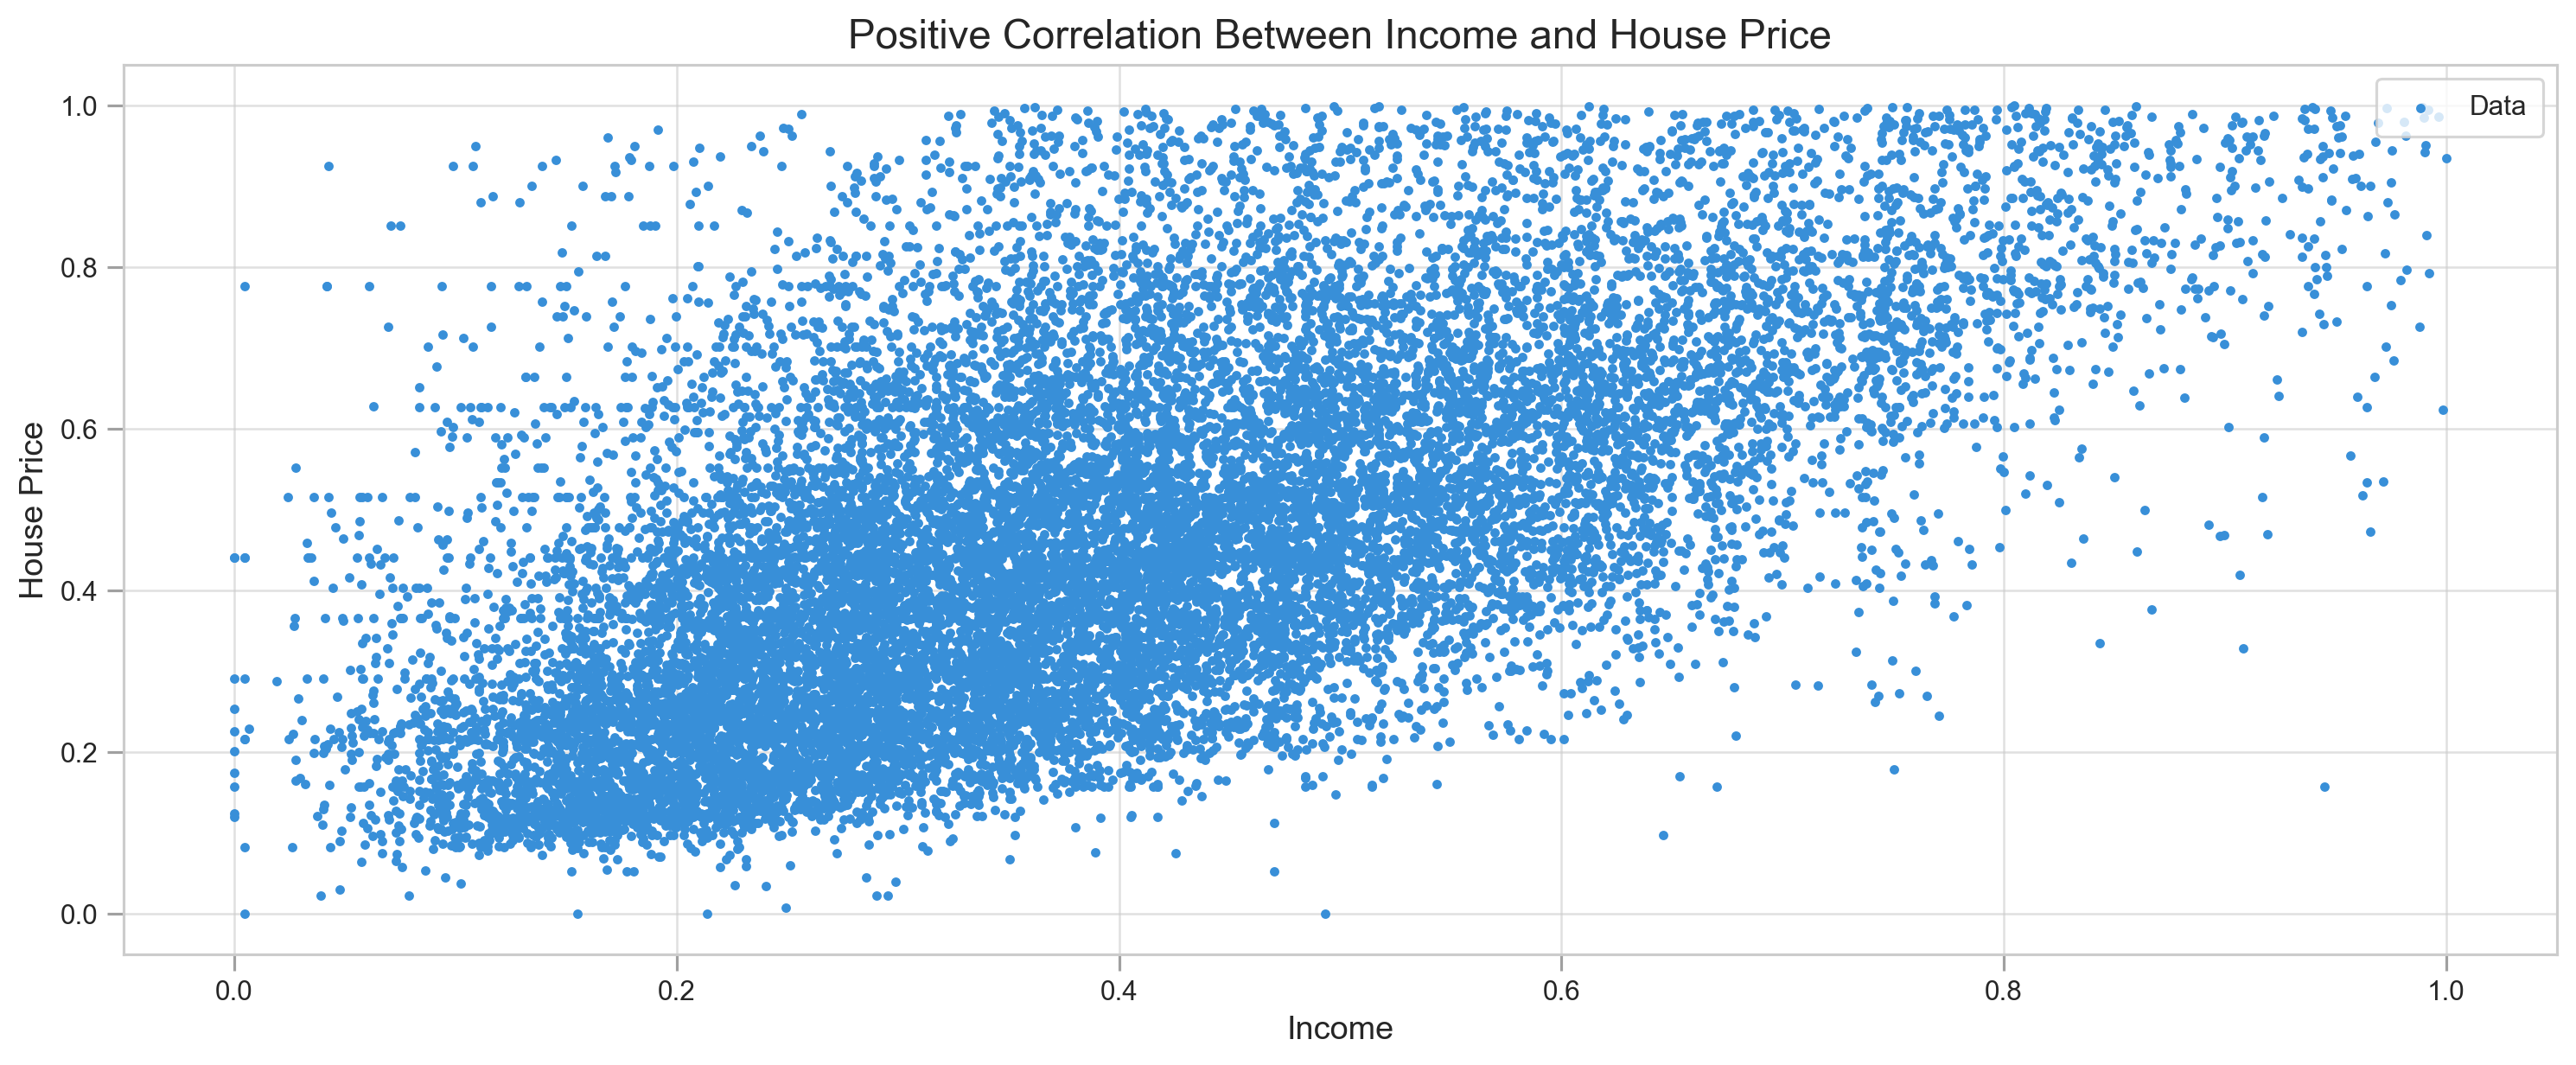

In [34]:
plt.figure(figsize=(16,6))
plt.rcParams['figure.dpi'] = 227
plt.style.use('seaborn-whitegrid')
plt.scatter(X, y, label='Data', c='#388fd8', s=6)
plt.title('Positive Correlation Between Income and House Price', fontsize=15)
plt.xlabel('Income', fontsize=12)
plt.ylabel('House Price', fontsize=12)
plt.legend(frameon=True, loc=1, fontsize=10, borderpad=.6)
plt.tick_params(direction='out', length=6, color='#a0a0a0', width=1, grid_alpha=.6)
plt.show()

Data is quite sparse, but we can still observe some linearity.

# Simple Linear Regression

Simple linear regression can be described by only two parameters: slope `m` and intercept `b`, where `x` is our **median income**. Lets take a look at the formulas below:

# $$\hat{y} = mx + b$$

### $$m = \frac{\overline{x}\overline{y}-\overline{xy}}{(\overline{x})^2 - \overline{x^2}} \quad \textrm{and} \quad  b = y-mx$$

If we want to add some other features, like size of the apartment, our formula would look like this: $\hat{y} = m_1x_1 + m_2x_2 + b$, where $m_1$ and $m_2$ are slopes for each feature $x_1$ and $x_2$. In this case we would call it multiple linear regression, but we could no longer use formulas above.

In [35]:
class SimpleLinearRegression:
        
    def fit(self, X, y):
        self.X = X
        self.y = y
        self.m = ((np.mean(X) * np.mean(y) - np.mean(X*y)) / ((np.mean(X)**2) - np.mean(X**2)))
        self.b = np.mean(y) - self.m * np.mean(X)
    
    def coeffs(self):
        return self.m, self.b
    
    def predict(self):
        self.y_pred = self.m * self.X + self.b
        return self.y_pred
    
    def r_squared(self):
        self.y_mean = np.full((len(self.y)), mean(self.y))
        err_reg = sum((self.y - self.y_pred)**2)
        err_y_mean = sum((self.y - self.y_mean)**2)
        return (1 - (err_reg/err_y_mean))

In [37]:
def plot_regression(X, y, y_pred, log=None, title="Linear Regression"):
    
    plt.figure(figsize=(16,6))
    plt.rcParams['figure.dpi'] = 227
    plt.scatter(X, y, label='Data', c='#388fd8', s=6)
    if log != None:
        for i in range(len(log)):
            plt.plot(X, log[i][0]*X + log[i][1], lw=1, c='#caa727', alpha=0.35)
    plt.plot(X, y_pred, c='#ff7702', lw=3, label='Regression')
    plt.title(title, fontsize=14)
    plt.xlabel('Income', fontsize=11)
    plt.ylabel('Price', fontsize=11)
    plt.legend(frameon=True, loc=1, fontsize=10, borderpad=.6)
    plt.tick_params(direction='out', length=6, color='#a0a0a0', width=1, grid_alpha=.6)
    plt.show()

In [38]:
X = df.MedInc
y = df.Target

In [39]:
lr = SimpleLinearRegression()

In [40]:
lr.fit(X, y)

In [41]:
y_pred = lr.predict()

MSE: 0.34320521502255963


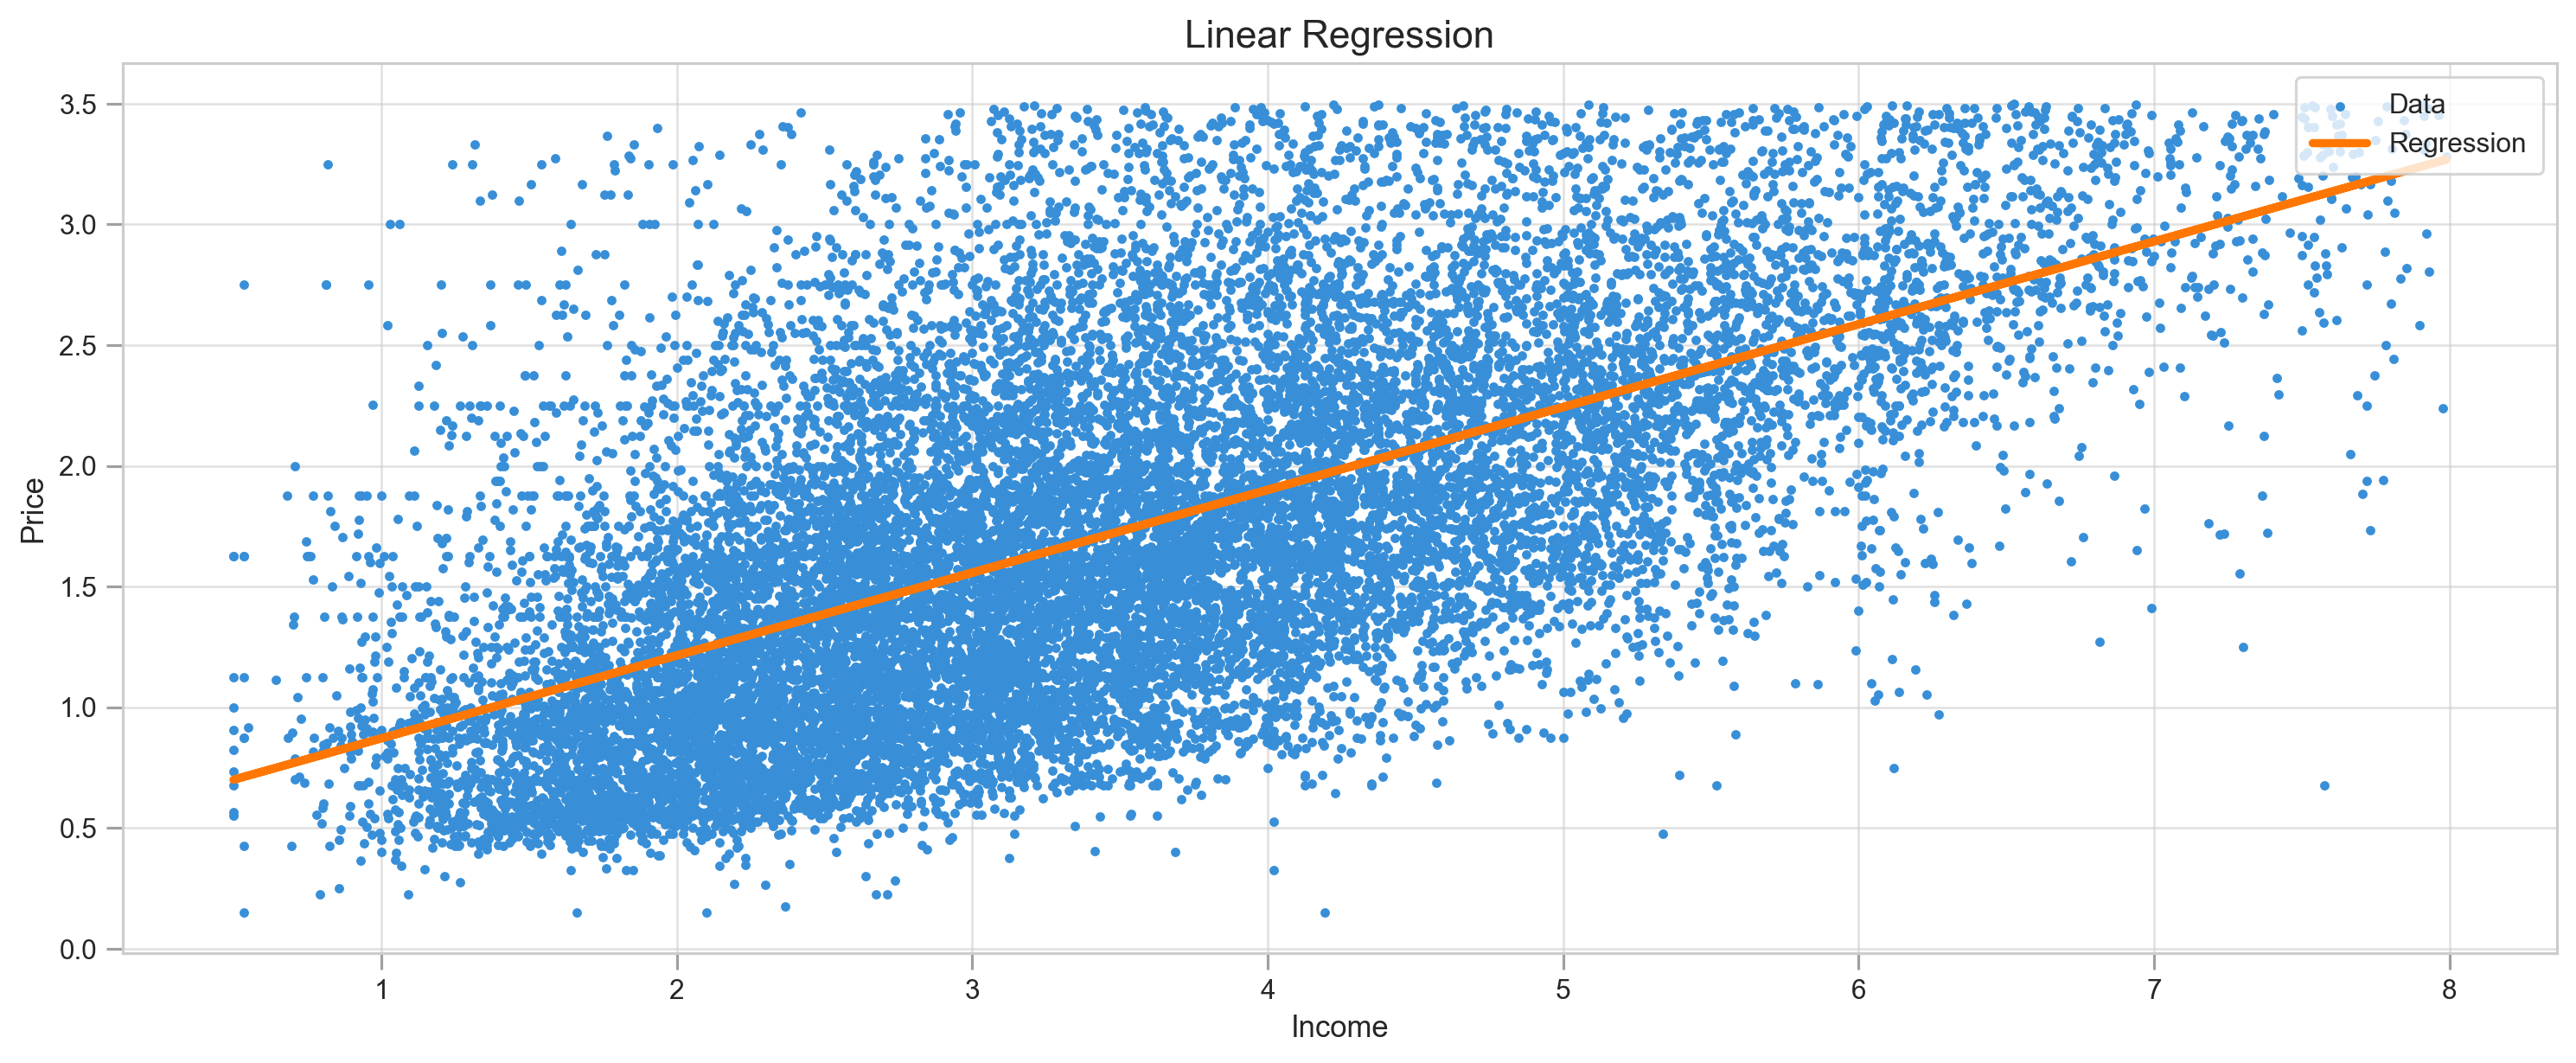

In [42]:
print("MSE:",mean_squared_error(y, y_pred))
plot_regression(X, y, y_pred, title="Linear Regression")

Result of our model is the regression line. Just by looking at the graph we can tell that data points go well above and beyond our line, making predictions approximate.

## Multiple Linear Regression with Least Squares

Similar to `from sklearn.linear_model import LinearRegression`, we can calculate coefficients with Least Squares method. Numpy can calculate this formula almost instantly (of course depends on the amount of data) and precise.

## $$ m =(A^TA)^{-1} A^Ty $$

### $$m - parameters, \: A - data, \: y - target$$

In [43]:
X = df.drop('Target', axis=1) # matrix A, or all the features
y = df.Target

In [44]:
class MultipleLinearRegression:
    '''
    Multiple Linear Regression with Least Squares    
    '''    
    def fit(self, X, y):
        X = np.array(X)
        y = np.array(y)
        self.coeffs = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(y)
        
    def predict(self, X):
        X = np.array(X)
        result = np.zeros(len(X))
        for i in range(X.shape[1]):
            result += X[:, i] * self.coeffs[i]
        return result
    
    def coeffs(self):
        return self.coeffs

In [45]:
mlp = MultipleLinearRegression()

In [46]:
mlp.fit(X, y)

In [47]:
y_pred = mlp.predict(X)

In [48]:
mean_squared_error(y, y_pred)

0.2912984534321039

# Gradient Descent

### Abstract

The idea behind gradient descent is simple - by gradually tuning parameters, such as slope (`m`) and the intercept (`b`) in our regression function `y = mx + b`, we minimize cost. 
By cost, we usually mean some kind of a function that tells us how far off our model predicted result. For regression problems we often use `mean squared error` (MSE) cost function. If we use gradient descent for the classification problem, we will have a different set of parameters to tune.

### $$ MSE = \frac{1}{n}\sum_{i=1}^{n} (y_i - \hat{y_i})^2 \quad \textrm{where} \quad \hat{y_i} = mx_i + b $$

Now we have to figure out how to tweak parameters `m` and `b` to reduce MSE.

### Partial Derivatives

We use partial derivatives to find how each individual parameter affects MSE, so that's where word _partial_ comes from. In simple words, we take the derivative with respect to `m` and `b` **separately**. Take a look at the formula below. It looks almost exactly the same as MSE, but this time we added f(m, b) to it. It essentially changes nothing, except now we can plug `m` and `b` numbers into it and calculate the result.

### $$𝑓(𝑚,𝑏)= \frac{1}{n}\sum_{i=1}^{n}(y_i - (mx_i+b))^2$$

This formula (or better say function) is better representation for further calculations of partial derivatives. We can ignore sum for now and what comes before that and focus only on $y - (mx + b)^2$.

### Partical Derivative With Respect to `m`

With respect to `m` means we derive parameter `m` and basically ignore what is going on with `b`, or we can say its 0. To derive with respect to `m` we will use chain rule.

# $$ [f(g(x))]' = f'(g(x)) * g(x)' \: - \textrm{chain rule}$$

Chain rule applies when one function sits inside of another. If you're new to this, you'd be surprised that $()^2$ is outside function, and $y-(\boldsymbol{m}x+b)$ sits inside it. So, the chain rule says that we should take a derivative of outside function, keep inside function unchanged and then multiply by derivative of the inside function. Lets write these steps down:

# $$ (y - (mx + b))^2 $$

 1. Derivative of $()^2$ is $2()$, same as $x^2$ becomes $2x$
 2. We do nothing with $y - (mx + b)$, so it stays the same
 3. Derivative of $y - (mx + b)$ with respect to **_m_** is $(0 - (x + 0))$ or $-x$, because **_y_** and **_b_** are constants, they become 0, and derivative of **_mx_** is **_x_**
 
Multiply all parts we get following: $2 * (y - (mx+b)) * -x$. 
Looks nicer if we move -x to the left: $-2x *(y-(mx+b))$. There we have it. The final version of our derivative is the following:

### $$\frac{\partial f}{\partial m} = \frac{1}{n}\sum_{i=1}^{n}-2x_i(y_i - (mx_i+b))$$

Here, $\frac{df}{dm}$ means we find partial derivative of function f (we mentioned it earlier) with respect to m. We plug our derivative to the summation and we're done.

### Partical Derivative With Respect to `b`

Same rules apply to the derivative with respect to b.

1. $()^2$ becomes $2()$, same as $x^2$ becomes $2x$
2. $y - (mx + b)$ stays the same
3. $y - (mx + b)$ becomes $(0 - (0 + 1))$ or $-1$, because **_y_** and **_mx_** are constants, they become 0, and derivative of **_b_** is 1

Multiply all the parts together and we get $-2(y-(mx+b))$

### $$\frac{\partial f}{\partial b} = \frac{1}{n}\sum_{i=1}^{n}-2(y_i - (mx_i+b))$$

### Final Function

Few details we should discuss befor jumping into code:
1. Gradient descent is an iterative process and with each iteration (`epoch`) we slightly minimizing MSE, so each time we use our derived functions to update parameters `m` and `b`
2. Because its iterative, we should choose how many iterations we take, or make algorithm stop when we approach minima of MSE. In other words when algorithm is no longer improving MSE, we know it reached minimum.
3. Gradient descent has an additional parameter learning rate (`lr`), which helps control how fast or slow algorithm going towards minima of MSE

Thats about it. So you can already understand that Gradient Descent for the most part is just process of taking derivatives and using them over and over to minimize function.

In [49]:
def gradient_descent(X, y, lr=0.05, epoch=10):
    
    '''
    Gradient Descent for a single feature
    '''
    
    m, b = 0.2, 0.2 # parameters
    log, mse = [], [] # lists to store learning process
    N = len(X) # number of samples
    
    for _ in range(epoch):
                
        f = y - (m*X + b)
    
        # Updating m and b
        m -= lr * (-2 * X.dot(f).sum() / N)
        b -= lr * (-2 * f.sum() / N)
        
        log.append((m, b))
        mse.append(mean_squared_error(y, (m*X + b)))        
    
    return m, b, log, mse

### Predicting House Price With Gradient Descent

MSE: 0.3493097403876614


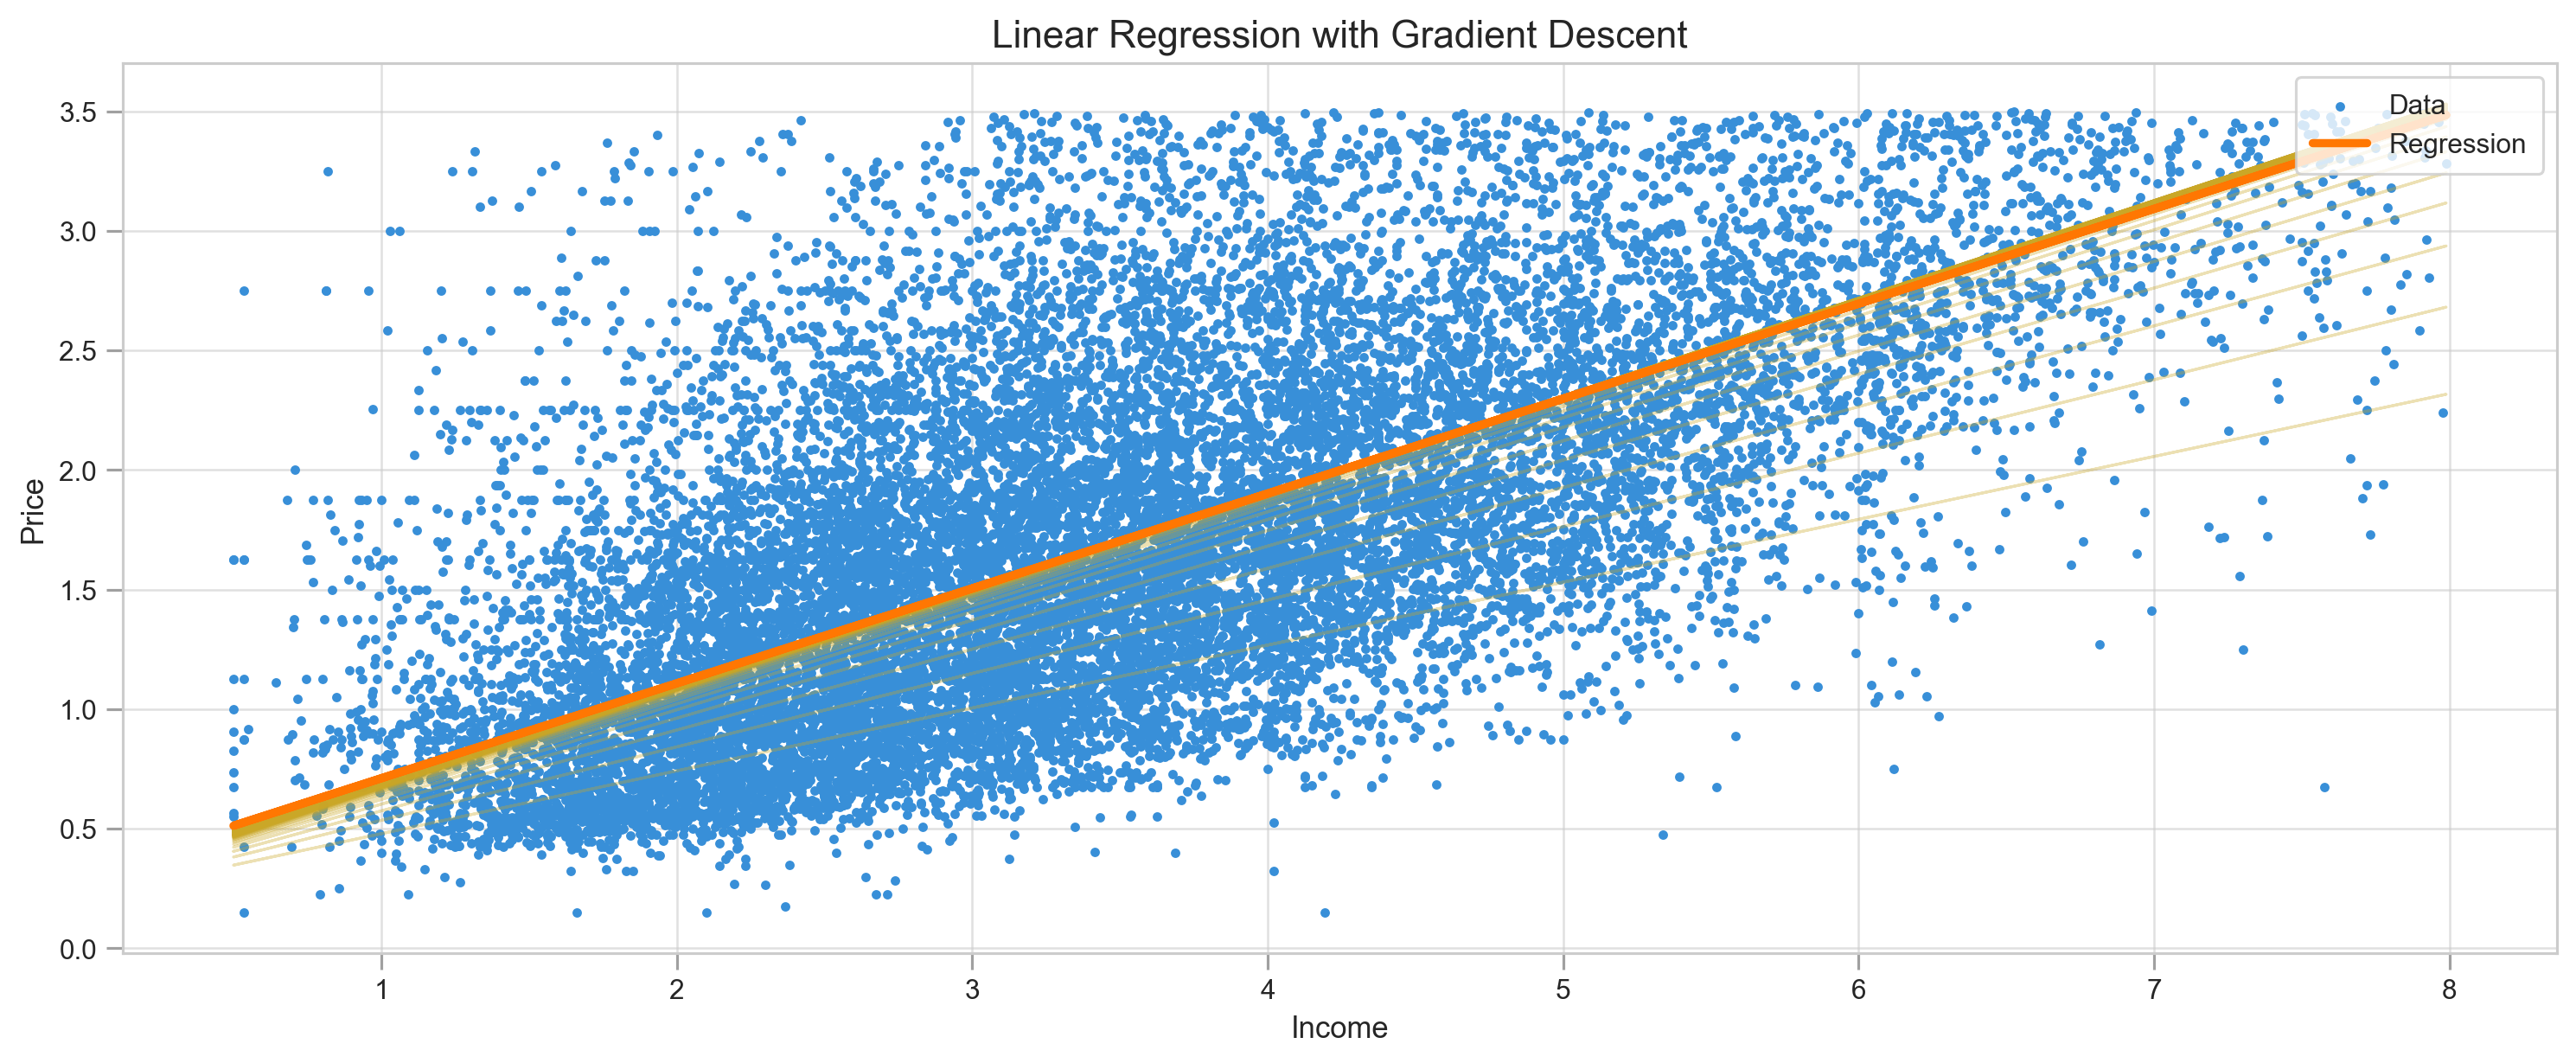

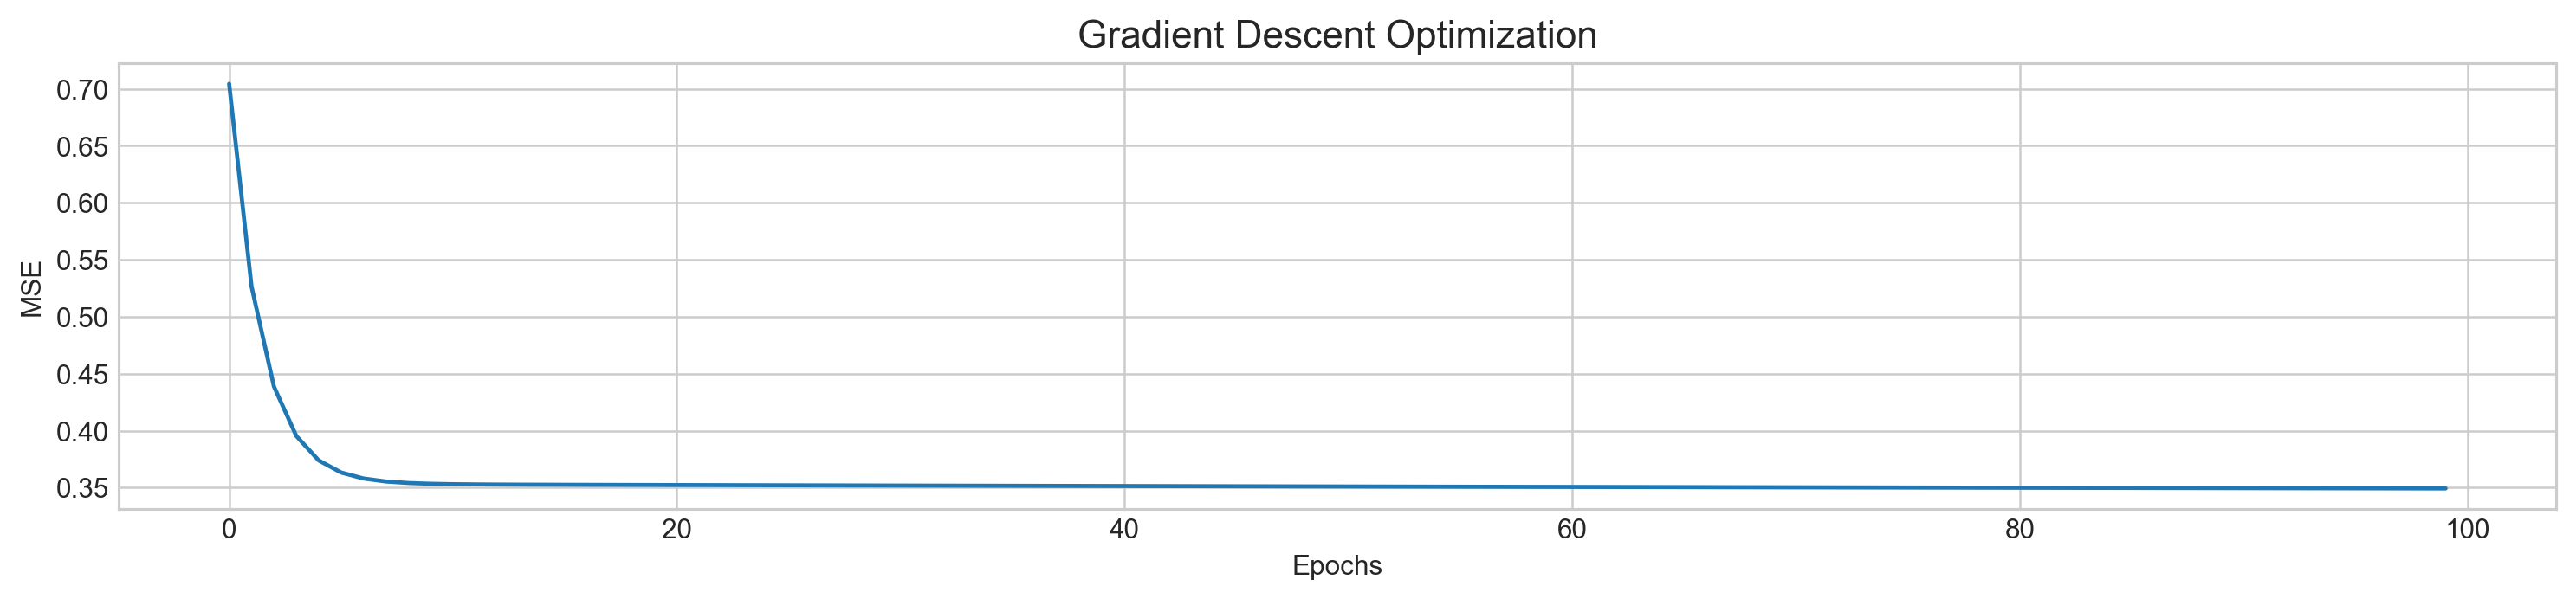

In [50]:
X = df.MedInc
y = df.Target

m, b, log, mse = gradient_descent(X, y, lr=0.01, epoch=100)

y_pred = m*X + b

print("MSE:",mean_squared_error(y, y_pred))
plot_regression(X, y, y_pred, log=log, title="Linear Regression with Gradient Descent")

plt.figure(figsize=(16,3))
plt.rcParams['figure.dpi'] = 227
plt.plot(range(len(mse)), mse)
plt.title('Gradient Descent Optimization', fontsize=14)
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.show()

## Stochastic Gradient Descent

Stochastic Gradient Descent works almost the same as Gradient Descent (also called Batch Gradient Descent), but instead of training on entire dataset, it picks only one sample to update `m` and `b` parameters, which makes it much faster. In the function below I made possible to change sample size (`batch_size`), because sometimes its better to use more than one sample at a time.

In [51]:
def SGD(X, y, lr=0.05, epoch=10, batch_size=1):
        
    '''
    Stochastic Gradient Descent for a single feature
    '''
    
    m, b = 0.5, 0.5 # initial parameters
    log, mse = [], [] # lists to store learning process
    
    for _ in range(epoch):
        
        indexes = np.random.randint(0, len(X), batch_size) # random sample
        
        Xs = np.take(X, indexes)
        ys = np.take(y, indexes)
        N = len(Xs)
        
        f = ys - (m*Xs + b)
        
        # Updating parameters m and b
        m -= lr * (-2 * Xs.dot(f).sum() / N)
        b -= lr * (-2 * f.sum() / N)
        
        log.append((m, b))
        mse.append(mean_squared_error(y, m*X+b))        
    
    return m, b, log, mse

In [52]:
m, b, log, mse = SGD(X, y, lr=0.01, epoch=100, batch_size=2)

MSE: 0.4020391124251626


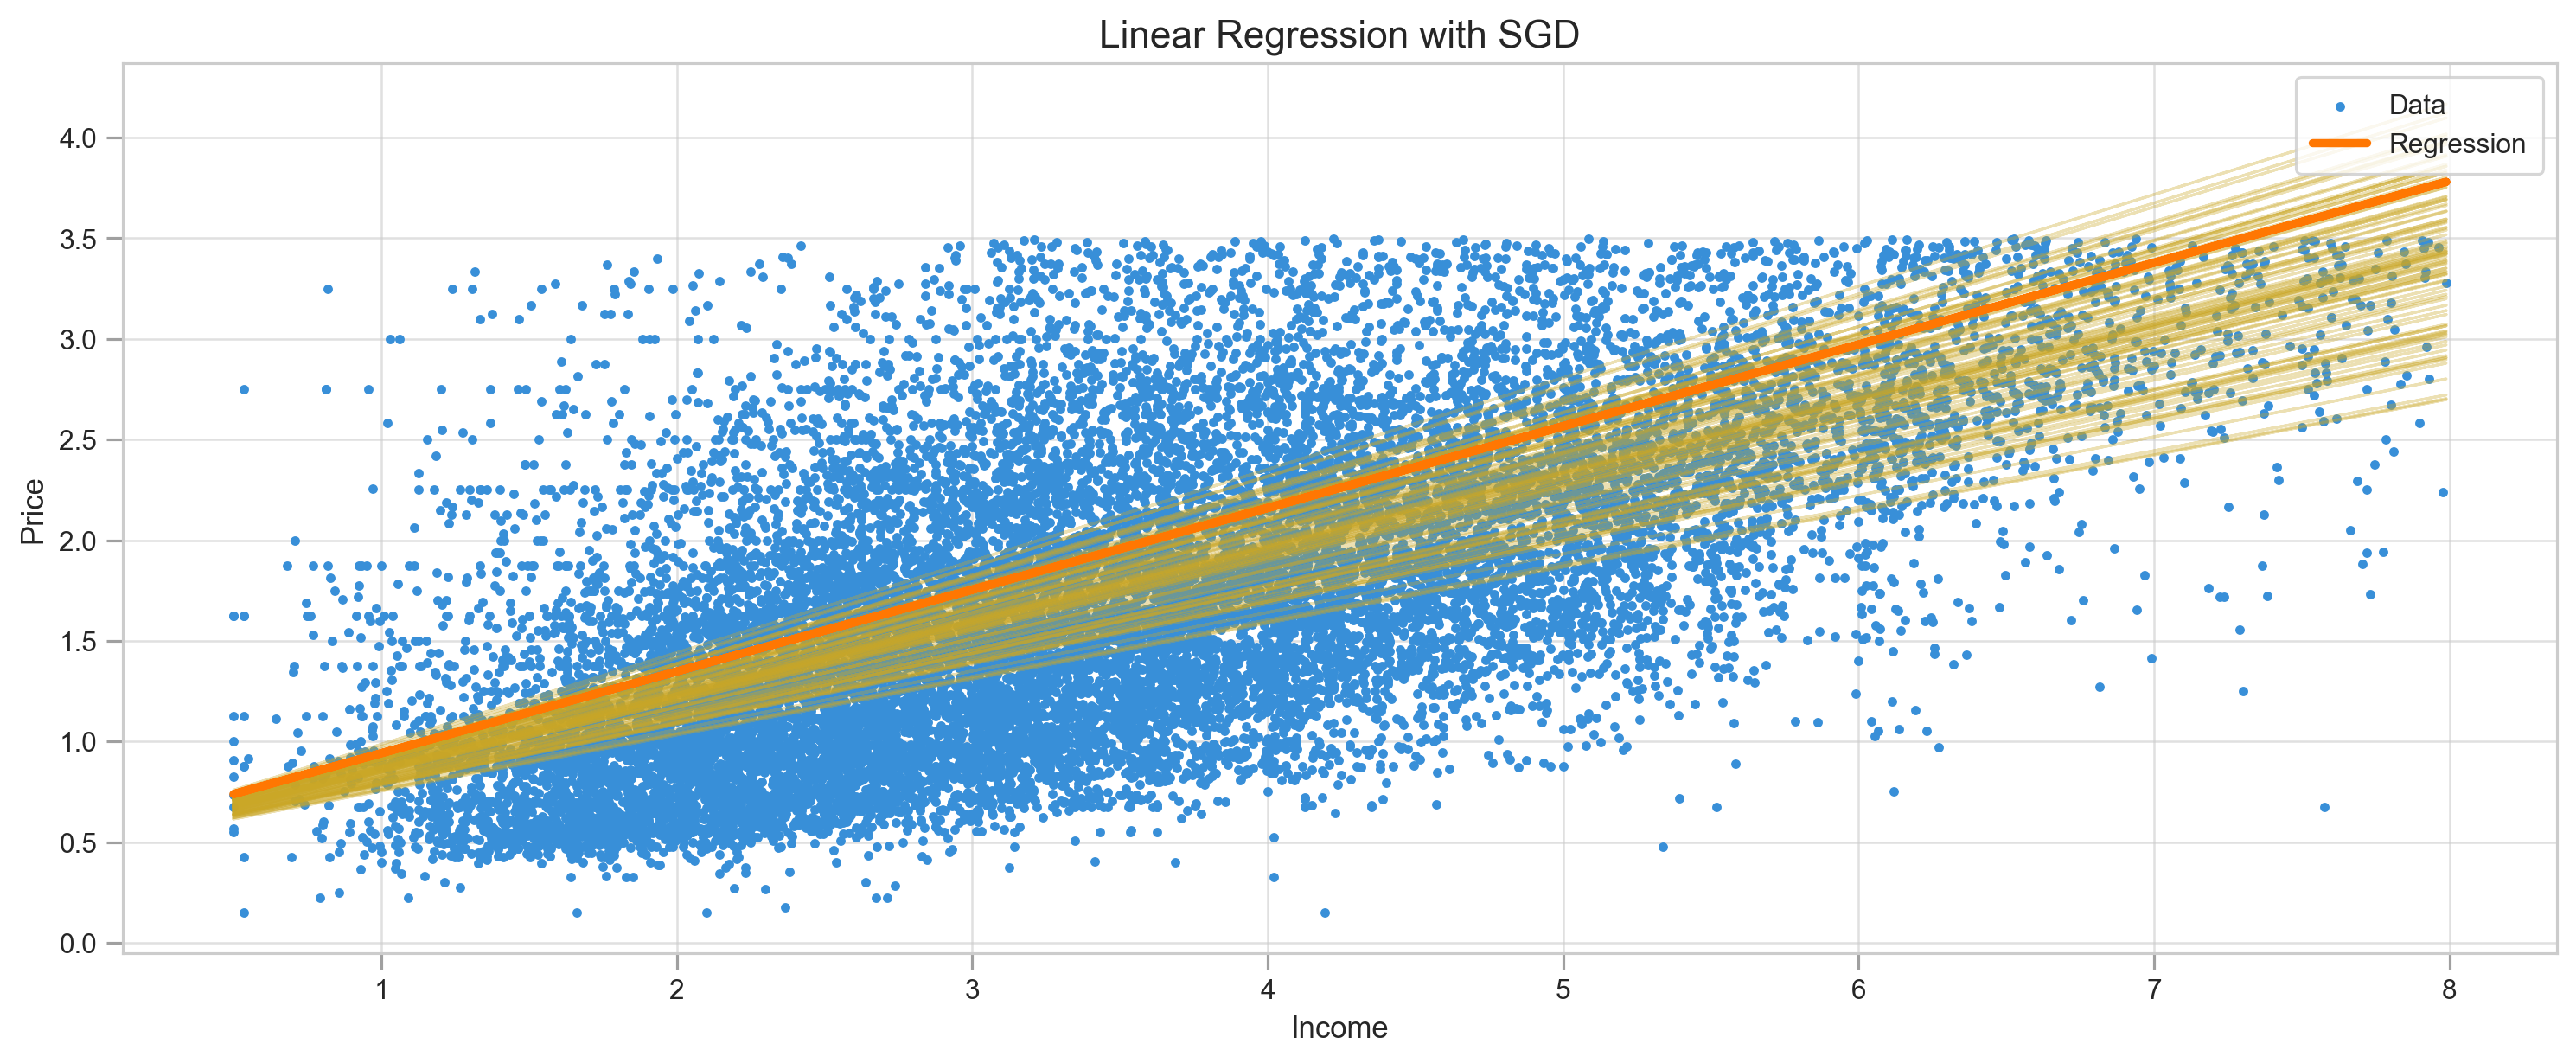

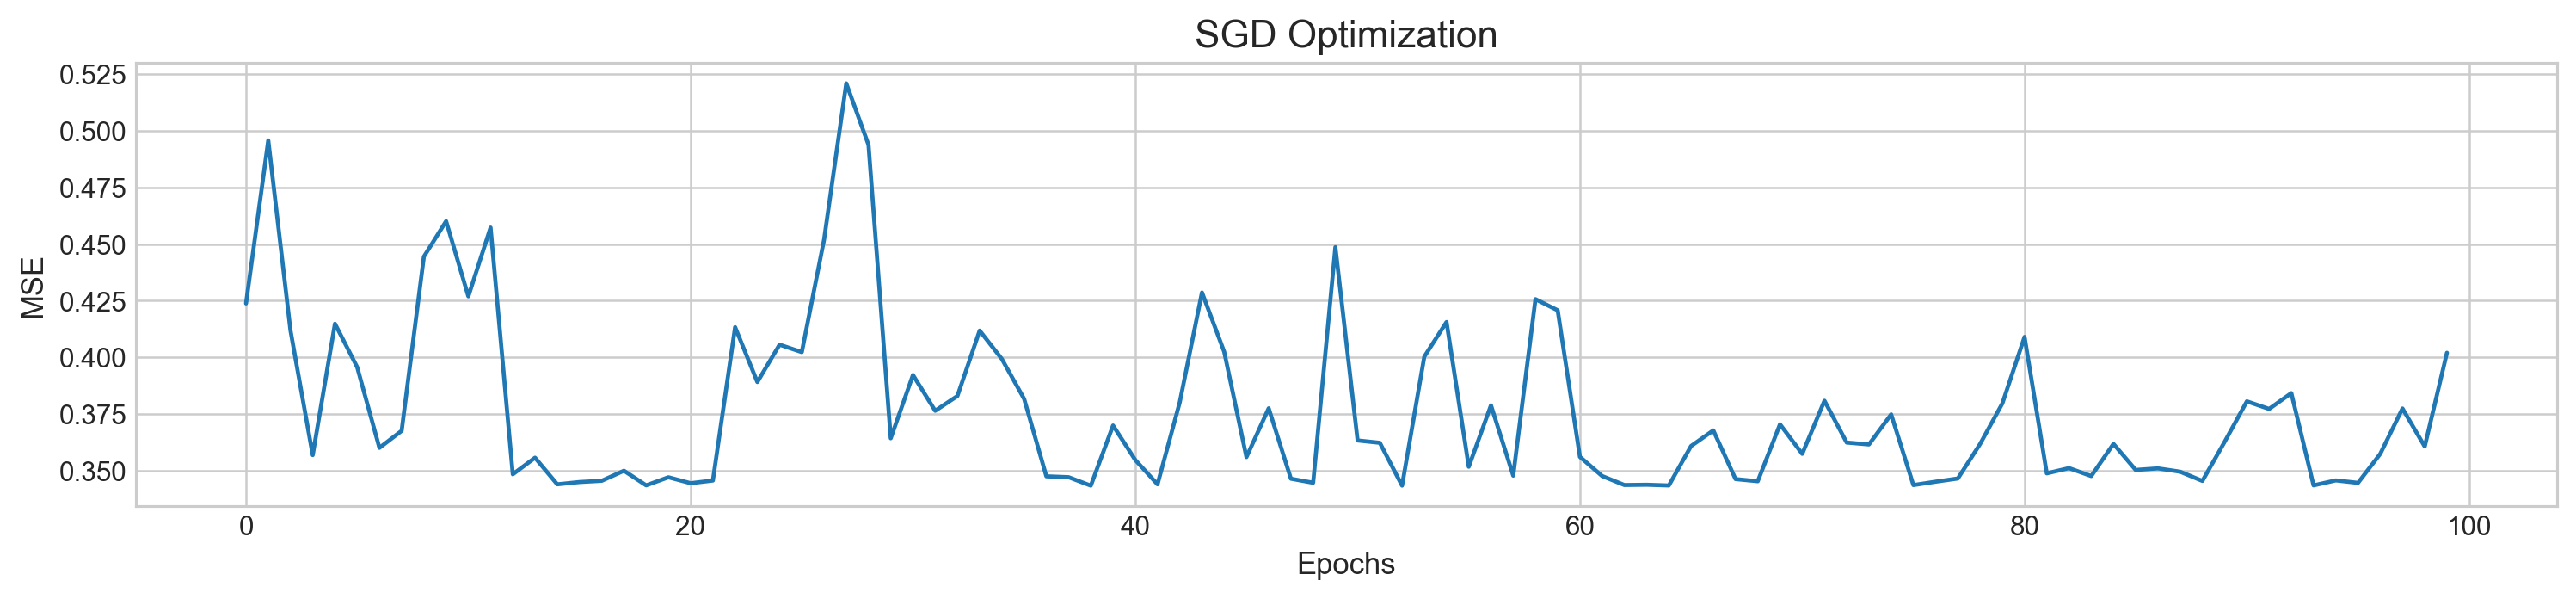

In [53]:
y_pred = m*X + b

print("MSE:",mean_squared_error(y, y_pred))
plot_regression(X, y, y_pred, log=log, title="Linear Regression with SGD")

plt.figure(figsize=(16,3))
plt.rcParams['figure.dpi'] = 227
plt.plot(range(len(mse)), mse)
plt.title('SGD Optimization', fontsize=14)
plt.xlabel('Epochs', fontsize=11)
plt.ylabel('MSE', fontsize=11)
plt.show()

We can observe how regression line went up and down to find right parameters and MSE not as smooth as regular gradient descent.

## Speed Test for Gradient Descent vs SGD

In [54]:
X = df.MedInc
y = df.Target

In [55]:
X = np.concatenate((X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X))
y = np.concatenate((y,y,y,y,y,y,y,y,y,y,y,y,y,y,y,y,y))

In [56]:
X.shape, y.shape

((304946,), (304946,))

In [57]:
%timeit SGD(X, y, lr=0.01, epoch=1000, batch_size=1)

1.45 s ± 147 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [58]:
%timeit gradient_descent(X, y, lr=0.01, epoch=1000)

2.09 s ± 112 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## Conclusion

1. SGD is twice as fast as Gradient Descent (also called Batch Gradient Descent)
2. On sparse data, we can increase the batch size to speed up learning process. It's not a pure form of SGD, but we can call it a mini-batch SGD
3. Smaller learning rate helps to prevent overfitting but can be adjusted accordingly